# Jet Compression using an Autoencoder

In [1]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

## Loading and preparing the data

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


In [3]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


## Normalizing and splitting into train and test datasets

In [4]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Training

In [5]:
def mse_loss(input, target, size_average=None, reduce=None, reduction='mean'):
    # type: (Tensor, Tensor, Optional[bool], Optional[bool], str) -> Tensor
    r"""mse_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor

    Measures the element-wise mean squared error.

    See :class:`~torch.nn.MSELoss` for details.
    """
    if not (target.size() == input.size()):
        warnings.warn("Using a target size ({}) that is different to the input size ({}). "
                      "This will likely lead to incorrect results due to broadcasting. "
                      "Please ensure they have the same size.".format(target.size(), input.size()),
                      stacklevel=2)
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)

    ret = (input - target) ** 2
    factor = torch.full(ret.size(), 1)
    factor[:, 2] = 2.4
    ret = ret * factor
    if reduction != 'none':
        ret = torch.mean(ret) if reduction == 'mean' else torch.sum(ret)

    return ret

In [6]:
bs = 256  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()
loss_func = mse_loss

In [7]:
class AE_2D_v4(nn.Module):
    def __init__(self, n_features=4):
        super(AE_2D_v4, self).__init__()
        self.en1 = nn.Linear(n_features, 500)
        self.en2 = nn.Linear(500, 200)
        self.en3 = nn.Linear(200, 100)
        self.en4 = nn.Linear(100, 2)
        self.de1 = nn.Linear(2, 100)
        self.de2 = nn.Linear(100, 200)
        self.de3 = nn.Linear(200, 500)
        self.de4 = nn.Linear(500, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)


class AE_big_2D_v1(nn.Module):
    def __init__(self, n_features=4):
        super(AE_big_2D_v1, self).__init__()
        self.en1 = nn.Linear(n_features, 8)
        self.en2 = nn.Linear(8, 6)
        self.en3 = nn.Linear(6, 4)
        self.en4 = nn.Linear(4, 2)
        self.de1 = nn.Linear(2, 4)
        self.de2 = nn.Linear(4, 6)
        self.de3 = nn.Linear(6, 8)
        self.de4 = nn.Linear(8, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    

class AE_big_2D_v2(nn.Module):
    def __init__(self, n_features=4):
        super(AE_big_2D_v2, self).__init__()
        self.en1 = nn.Linear(n_features, 8)
        self.en2 = nn.Linear(8, 6)
        self.en3 = nn.Linear(6, 4)
        self.en4 = nn.Linear(4, 3)
        self.en5 = nn.Linear(3, 2)
        self.de1 = nn.Linear(2, 3)
        self.de2 = nn.Linear(3, 4)
        self.de3 = nn.Linear(4, 6)
        self.de4 = nn.Linear(6, 8)
        self.de5 = nn.Linear(8, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en5(self.tanh(self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))))

    def decode(self, x):
        return self.de5(self.tanh(self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [8]:
n_features = len(train.loc[0])
model = AE_2D_v4(n_features=n_features)

In [9]:
# Training
#epochs_list = [7, 5, 3, 2, 2]
epochs_list = [40, 40, 20, 20, 20]
lrs = [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    #opt = optim.SGD(model.parameters(), lr=lrs[ii], momentum=0.9, nesterov=True)
    #opt = optim.RMSprop(model.parameters(), lr=lrs[ii], momentum=0.9)
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-03
Epoch 0: Validation loss = 0.09917712500052378 Time: 0:01:46.001218
Epoch 1: Validation loss = 0.06691280282728256 Time: 0:03:44.401854
Epoch 2: Validation loss = 0.06049868041028967 Time: 0:05:39.306010
Epoch 3: Validation loss = 0.050589683119815876 Time: 0:07:31.509556
Epoch 4: Validation loss = 0.05212372198273686 Time: 0:09:27.061068
Epoch 5: Validation loss = 0.046884935217969395 Time: 0:11:26.516637
Epoch 6: Validation loss = 0.04977573368058829 Time: 0:13:21.818458
Epoch 7: Validation loss = 0.05824225506348945 Time: 0:15:17.201865
Epoch 8: Validation loss = 0.0578519071894496 Time: 0:17:10.482915
Epoch 9: Validation loss = 0.057781950954865983 Time: 0:19:03.673172
Epoch 10: Validation loss = 0.062180033192877786 Time: 0:20:57.794851
Epoch 11: Validation loss = 0.05037205850111894 Time: 0:22:53.233150
Epoch 12: Validation loss = 0.07733656779721657 Time: 0:24:48.843532
Epoch 13: Validation loss = 0.051605829915449174 Time: 0:26:46.358771
Epoch 1

KeyboardInterrupt: 

In [18]:
# Training
#epochs_list = [7, 5, 3, 2, 2]
epochs_list = [40, 40, 20, 20, 20]
lrs = [1e-4, 3e-5, 1e-5, 3e-6, 1e-6]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    #opt = optim.SGD(model.parameters(), lr=lrs[ii], momentum=0.9, nesterov=True)
    #opt = optim.RMSprop(model.parameters(), lr=lrs[ii], momentum=0.9)
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-04
Epoch 0: Validation loss = 0.04569737370452363 Time: 0:02:01.312164
Epoch 1: Validation loss = 0.040860326772510926 Time: 0:04:04.580689
Epoch 2: Validation loss = 0.039413360778099975 Time: 0:06:12.935652
Epoch 3: Validation loss = 0.03743960152231805 Time: 0:08:16.513263
Epoch 4: Validation loss = 0.03853967781898337 Time: 0:10:23.235722
Epoch 5: Validation loss = 0.03807254872157545 Time: 0:12:22.970152
Epoch 6: Validation loss = 0.03931128176306979 Time: 0:14:28.259433
Epoch 7: Validation loss = 0.03618021280459134 Time: 0:16:31.074749
Epoch 8: Validation loss = 0.0362620974385779 Time: 0:18:30.527533
Epoch 9: Validation loss = 0.03546568373786914 Time: 0:20:43.021996
Epoch 10: Validation loss = 0.040218299719522024 Time: 0:22:46.782470
Epoch 11: Validation loss = 0.03774544177413141 Time: 0:24:56.233698
Epoch 12: Validation loss = 0.03696653691761213 Time: 0:26:53.804189
Epoch 13: Validation loss = 0.03582537403321254 Time: 0:29:08.866808
Epoch 14:

Epoch 17: Validation loss = 0.029045677943829586 Time: 0:36:59.318196
Epoch 18: Validation loss = 0.029180262915749308 Time: 0:39:02.638873
Epoch 19: Validation loss = 0.02915207592354374 Time: 0:41:00.381459
Setting learning rate to 1.0e-06
Epoch 0: Validation loss = 0.029087334087539503 Time: 0:01:54.222677
Epoch 1: Validation loss = 0.029262860008484996 Time: 0:03:55.638858
Epoch 2: Validation loss = 0.029194733837540794 Time: 0:05:52.142980
Epoch 3: Validation loss = 0.029149565334114568 Time: 0:07:47.292815
Epoch 4: Validation loss = 0.029165908386910952 Time: 0:09:42.443802
Epoch 5: Validation loss = 0.02904407138824633 Time: 0:11:35.982972
Epoch 6: Validation loss = 0.029173030531593428 Time: 0:13:32.953935
Epoch 7: Validation loss = 0.029109433311638355 Time: 0:15:39.203757
Epoch 8: Validation loss = 0.02912675685952738 Time: 0:17:44.282956
Epoch 9: Validation loss = 0.02920989201739089 Time: 0:19:42.397063
Epoch 10: Validation loss = 0.029086356171346854 Time: 0:21:49.506372
E

In [28]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/AE_2D_v4_bs256_loss0029.pt'
#torch.save(model.state_dict(), save_path)
# model_big = AE_big()
# model_big.load_state_dict(torch.load(save_path))
# model_big.eval()

## Evaluation

In [20]:
model.eval()

AE_2D_v4(
  (en1): Linear(in_features=4, out_features=500, bias=True)
  (en2): Linear(in_features=500, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=100, bias=True)
  (en4): Linear(in_features=100, out_features=2, bias=True)
  (de1): Linear(in_features=2, out_features=100, bias=True)
  (de2): Linear(in_features=100, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=500, bias=True)
  (de4): Linear(in_features=500, out_features=4, bias=True)
  (tanh): Tanh()
)

In [21]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.5689, -0.7369,  1.5201,  0.2501], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1592, -0.0968, -0.0432, -0.5799], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3236,  0.5658,  1.2809, -0.5848], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.4003,  0.1253,  1.0852, -0.7265], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7787, -0.0897,  1.1638, -0.7953], grad_fn=<AddBackward0>)
 


In [22]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([430.8397,  -1.1533,   3.0955, 751.4479])
Out: [416.5982     -1.1969614   2.7775276 738.8829   ]
 
Inp: tensor([ 2.4776e+02, -2.8475e-01, -4.7715e-02,  2.5939e+02])
Out: [ 2.4565479e+02 -1.7614028e-01 -6.9793627e-02  2.6688556e+02]
 
Inp: tensor([180.9266,   1.0163,   2.3835, 283.3568])
Out: [187.10292     0.8807374   2.3419592 264.08884  ]
 
Inp: tensor([ 1.8135e+02, -3.3156e-02,  1.9931e+00,  1.8195e+02])
Out: [1.7780713e+02 1.7813803e-01 1.9854852e+00 1.8352460e+02]
 
Inp: tensor([131.5479,  -0.6542,   2.1167, 160.9622])
Out: [131.91318     -0.16476624   2.128555   144.40927   ]
 


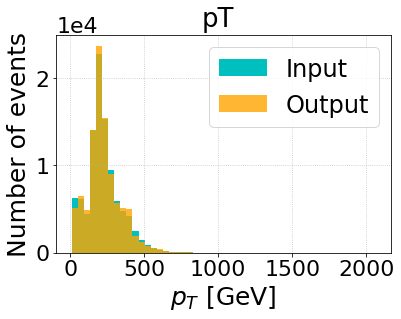

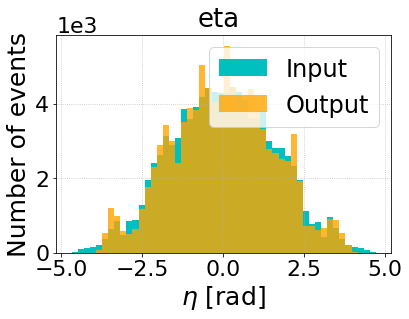

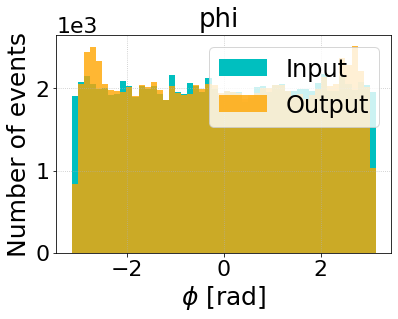

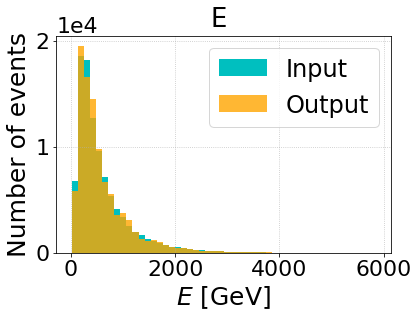

In [23]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    plt.legend()
    ms.sciy()

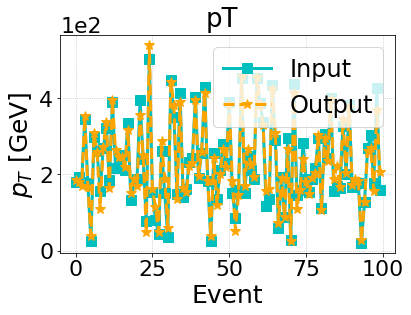

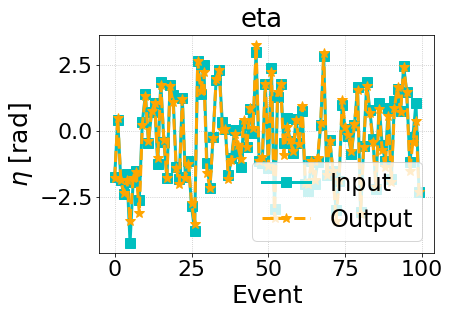

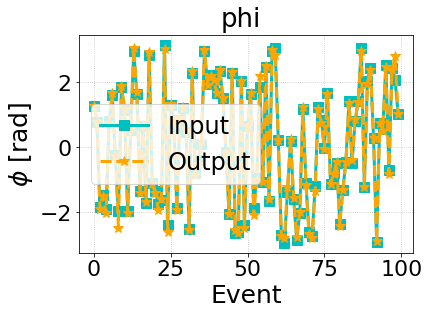

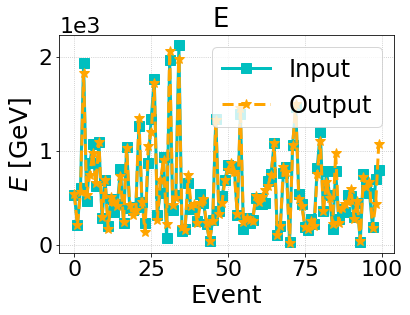

In [24]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [25]:
# Plot input on top of output
idxs = (0, int(1e5))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

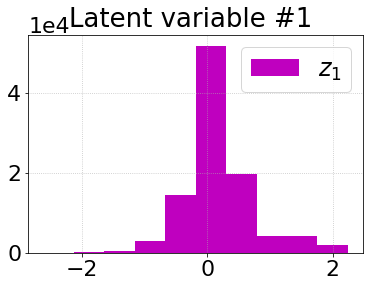

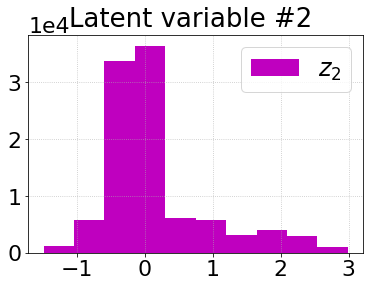

In [26]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m')
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()

Text(0, 0.5, '$z_2$')

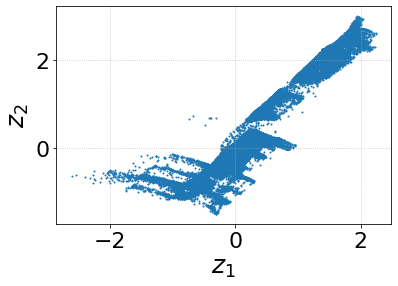

In [27]:
mksz = 1

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')